## Rappel Google Colab

Tout d'abord, sélectionnez l'option GPU de Colab avec *Edit > Notebook settings* et sélectionner GPU comme Hardware accelerator. 
Installer ensuite deeplib avec la commande suivante:

In [ ]:
!pip install git+https://github.com/ulaval-damas/glo4030-labs.git

# Laboratoire 4: Régularisation

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import math
import poutyne as pt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from deeplib.datasets import load_cifar10, load_mnist, train_valid_loaders
from deeplib.net import CifarNet, CifarNetBatchNorm
from deeplib.training import train, test

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150

cifar_train, cifar_test = load_cifar10()
mnist_train, mnist_test = load_mnist()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/workspace/glo4030-labs/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 170M/170M [00:10<00:00, 16.6MB/s] 
100%|██████████| 9.91M/9.91M [00:00<00:00, 68.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 2.19MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 19.7MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.91MB/s]


## Partie 1: Régularisation L1 et L2

### Implémentation manuelle
Dans la communauté de l'apprentissage profond, la régularisation L2 est communément appelée **weight decay**. 

Il est toutefois à noter que le **weight decay** et la régularisation L2 ne sont pas équivalents dans tous les cas. Ces deux méthodes sont équivalentes lorsque l'on utilise un optimiseur de type SGD, mais elles ne le sont pas pour des optimiseurs à gradients adaptatifs comme Adam. Voir l'article [Decoupled Weight Decay Regularization](https://arxiv.org/pdf/1711.05101.pdf) pour plus de détails sur la distinction entre ces deux méthodes.

Dans le cadre de ce laboratoire, on utilise exclusivement l'optimiseur SGD, on peut donc considérer les termes **weight decay** et la régularisation L2 comme équivalents.

Dans PyTorch, les optimiseurs de `torch.optim` ont un paramètre `weight_decay` pour utiliser cette régularisation. Par contre, on peut facilement implémenter manuellement la régularisation L2 comme une pénalité sur la norme des poids (voir le [chapitre 7.1](http://www.deeplearningbook.org/contents/regularization.html)).

#### Exercice
 - Complétez la fonction *loss_init* en ajoutant manuellement la pénalité sur les paramètres du réseau selon une régularisation L1 ou L2. Le paramètre *reg_alpha* correspond à l'hyperparamètre de régularisation $\alpha$ du livre ($\lambda$ dans les acétates du cours). Le paramètre *p* correspond à l'ordre de la norme: $p=1$ pour la norme L1 et $p=2$ pour la norme L2.

In [ ]:
def loss_init(parameters=[], reg_alpha=0, p=2):
    cross_entropy = nn.CrossEntropyLoss()
    
    def loss_function(output, targets):
        loss = cross_entropy(output,targets)

        for param in parameters:
            # TODO Ajoutez la pénalité sur les paramètres
            loss += reg_alpha/p * torch.norm(param, p=p) ** p
        
        return loss
    return loss_function

Testez votre implémentation de la régularisation par la norme L2 ($p=2$):

In [6]:
torch.manual_seed(42)
net = CifarNet()

optimizer = optim.SGD(net.parameters(), lr=0.1)
loss = loss_init(list(net.parameters()), reg_alpha=1e-3, p=2)

history = train(net, optimizer, cifar_train, n_epoch=5, batch_size=64, use_gpu=True, criterion=loss)

Epoch: 1/5 Train steps: 625 Val steps: 157 12.52s loss: 1.933336 acc: 31.940000 val_loss: 1.605507 val_acc: 44.400000
Epoch: 2/5 Train steps: 625 Val steps: 157 11.29s loss: 1.475243 acc: 49.580000 val_loss: 1.377032 val_acc: 53.930000
Epoch: 3/5 Train steps: 625 Val steps: 157 11.29s loss: 1.289491 acc: 57.152500 val_loss: 1.250334 val_acc: 59.240000
Epoch: 4/5 Train steps: 625 Val steps: 157 11.44s loss: 1.153578 acc: 62.807500 val_loss: 1.129728 val_acc: 63.730000
Epoch: 5/5 Train steps: 625 Val steps: 157 11.45s loss: 1.046044 acc: 67.332500 val_loss: 1.080553 val_acc: 66.790000


Testez votre implémentation de la régularisation par la norme L1 ($p=1$):

In [7]:
torch.manual_seed(42)
net = CifarNet()
optimizer = optim.SGD(net.parameters(), lr=0.1)
loss = loss_init(list(net.parameters()), reg_alpha=1e-3, p=1)

history = train(net, optimizer, cifar_train, n_epoch=5, batch_size=64, use_gpu=True, criterion=loss)

Epoch: 1/5 Train steps: 625 Val steps: 157 10.77s loss: 2.774294 acc: 20.425000 val_loss: 2.116685 val_acc: 28.500000
Epoch: 2/5 Train steps: 625 Val steps: 157 10.52s loss: 2.082906 acc: 27.972500 val_loss: 1.950359 val_acc: 35.150000
Epoch: 3/5 Train steps: 625 Val steps: 157 10.59s loss: 1.932066 acc: 35.235000 val_loss: 1.902733 val_acc: 34.610000
Epoch: 4/5 Train steps: 625 Val steps: 157 10.57s loss: 1.857317 acc: 37.810000 val_loss: 1.802350 val_acc: 40.460000
Epoch: 5/5 Train steps: 625 Val steps: 157 10.41s loss: 1.810974 acc: 40.025000 val_loss: 1.762143 val_acc: 41.520000


### Utilisation du *weight decay*

Explorons maintenant l'utilisation du paramètre `weight_decay` disponible dans les optimiseurs de `PyTorch` pour effectuer de la régularisation L2. Nous allons entrainer un réseau de neurones avec régularisation L2 et un autre sans pour pouvoir observer l'impact de la régularisation sur l'apprentissage et le réseau appris.

In [8]:
# Paramètres
batch_size = 64
lr = 0.1
n_epoch = 15

Réseau sans régularisation L2:

Epoch:  1/15 Train steps: 625 Val steps: 157 7.42s loss: 1.888331 acc: 31.527500 val_loss: 1.540285 val_acc: 44.880000
Epoch:  2/15 Train steps: 625 Val steps: 157 7.33s loss: 1.393728 acc: 50.280000 val_loss: 1.278195 val_acc: 54.660000
Epoch:  3/15 Train steps: 625 Val steps: 157 6.31s loss: 1.178800 acc: 58.582500 val_loss: 1.129683 val_acc: 60.610000
Epoch:  4/15 Train steps: 625 Val steps: 157 6.30s loss: 1.021744 acc: 64.085000 val_loss: 1.004936 val_acc: 64.860000
Epoch:  5/15 Train steps: 625 Val steps: 157 6.25s loss: 0.896749 acc: 68.762500 val_loss: 0.969472 val_acc: 66.500000
Epoch:  6/15 Train steps: 625 Val steps: 157 6.21s loss: 0.800741 acc: 72.295000 val_loss: 0.951889 val_acc: 67.540000
Epoch:  7/15 Train steps: 625 Val steps: 157 6.39s loss: 0.711252 acc: 75.507500 val_loss: 0.912343 val_acc: 68.720000
Epoch:  8/15 Train steps: 625 Val steps: 157 6.32s loss: 0.630741 acc: 78.252500 val_loss: 0.990860 val_acc: 67.530000
Epoch:  9/15 Train steps: 625 Val steps: 157 6.3

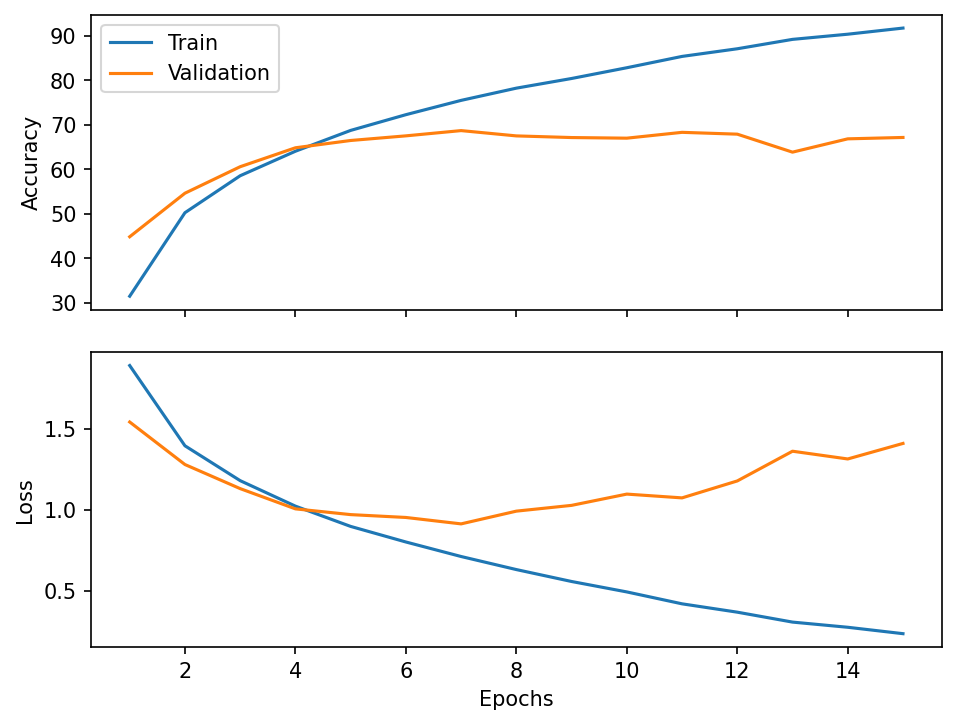

Test steps: 157 0.99s test_loss: 1.408219 test_acc: 67.150000                                 
Précision en test: 67.15


In [9]:
torch.manual_seed(42)
net_without_l2 = CifarNet()
optimizer_without_l2 = optim.SGD(net_without_l2.parameters(), lr=lr, weight_decay=0)

history_without_l2 = train(net_without_l2, optimizer_without_l2, cifar_train, n_epoch, batch_size, use_gpu=True)
history_without_l2.display()
print('Précision en test: {:.2f}'.format(test(net_without_l2, cifar_test, batch_size)))

Réseau avec régularisation L2 (*weight decay*):

Epoch:  1/15 Train steps: 625 Val steps: 157 7.44s loss: 1.899459 acc: 31.382500 val_loss: 1.544656 val_acc: 44.780000
Epoch:  2/15 Train steps: 625 Val steps: 157 6.26s loss: 1.424955 acc: 49.212500 val_loss: 1.323229 val_acc: 53.410000
Epoch:  3/15 Train steps: 625 Val steps: 157 6.48s loss: 1.224342 acc: 56.712500 val_loss: 1.221355 val_acc: 57.200000
Epoch:  4/15 Train steps: 625 Val steps: 157 6.28s loss: 1.073535 acc: 62.460000 val_loss: 1.039347 val_acc: 63.840000
Epoch:  5/15 Train steps: 625 Val steps: 157 6.26s loss: 0.953451 acc: 66.845000 val_loss: 0.986034 val_acc: 65.850000
Epoch:  6/15 Train steps: 625 Val steps: 157 6.71s loss: 0.863389 acc: 70.120000 val_loss: 0.939917 val_acc: 67.370000
Epoch:  7/15 Train steps: 625 Val steps: 157 6.32s loss: 0.790171 acc: 72.847500 val_loss: 0.923151 val_acc: 68.400000
Epoch:  8/15 Train steps: 625 Val steps: 157 6.24s loss: 0.719478 acc: 75.020000 val_loss: 0.962778 val_acc: 66.860000
Epoch:  9/15 Train steps: 625 Val steps: 157 6.3

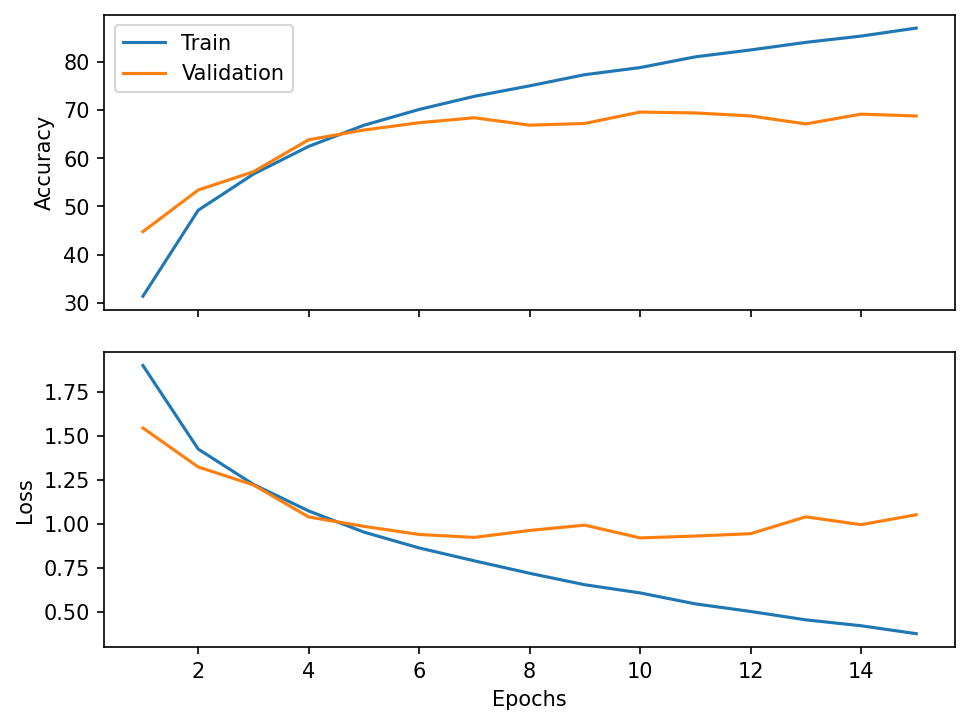

Test steps: 157 1.00s test_loss: 1.044557 test_acc: 68.480000                                 
Précision en test: 68.48


In [13]:
weight_decay = 1e-3

torch.manual_seed(42)
net_l2 = CifarNet()
optimizer_l2 = optim.SGD(net_l2.parameters(), lr=lr, weight_decay=weight_decay)

history_l2 = train(net_l2, optimizer_l2, cifar_train, n_epoch, batch_size, use_gpu=True)
history_l2.display()
print('Précision en test: {:.2f}'.format(test(net_l2, cifar_test, batch_size)))

#### Questions
- Quel est l'effet de la régularisation L2 sur l'entraînement du réseau? 

Moins de surapprentissage
    
- Si vous utilisez un `weight_decay` trop grand (exemple 0.1) qu'arrive-t-il? Pourquoi? 

Le réseau n'apprend pas car on met une trop grande pénalité

Dans la cellule suivante, analysez avec un histogramme la distribution des poids appris par les réseaux avec ou sans régularisation. 

- Que remarquez-vous? 

Variance moins élevé et plus de poids avec des valeurs très élevé
    
- Essayez d'autres valeurs de weight decay (1e-2, 1e-4) et observez l'impact sur la distribution des poids appris. 

Plus le decay augmente, moins la variance est élevée

Poids sans régularisation L2: variance 0.0057, maximum 1.6083.
Poids avec régularisation L2: variance 0.0031, maximum 1.3578.


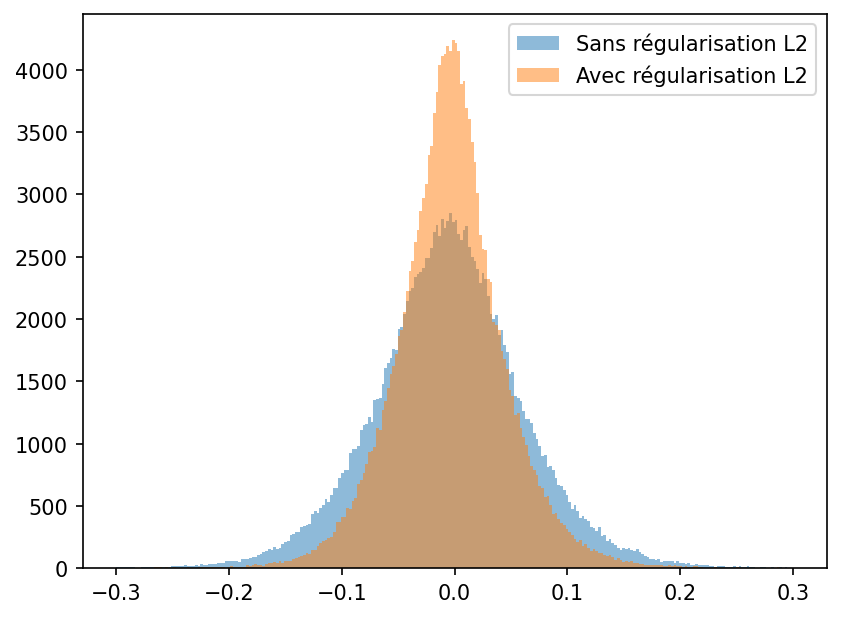

In [14]:
def net_to_weight_array(net):
    weights = []
    for p in net.parameters():
        p_numpy = p.data.cpu().numpy()
        weights.append(p_numpy.reshape((-1))) # Reshape to 1D array
    return np.concatenate(weights)

weights_without_l2 = net_to_weight_array(net_without_l2)
weights_l2 = net_to_weight_array(net_l2)

print("Poids sans régularisation L2: variance {:.4f}, maximum {:.4f}.".format(np.var(weights_without_l2), 
                                                                              np.max(np.abs(weights_without_l2))))
print("Poids avec régularisation L2: variance {:.4f}, maximum {:.4f}.".format(np.var(weights_l2), 
                                                                              np.max(np.abs(weights_l2))))

# Visualisation
plt.hist(weights_without_l2, bins=250, range=(-0.3, 0.3), alpha =0.5, label="Sans régularisation L2")
plt.hist(weights_l2, bins=250, range=(-0.3, 0.3), alpha=0.5, label="Avec régularisation L2")
plt.legend()
plt.show()

## Partie 2: Early stopping

Commencez par entraîner un réseau pour un grand nombre d'époques. L'historique d'entraînement nous servira de base pour les questions qui suivent.

In [15]:
torch.manual_seed(42)
net = CifarNetBatchNorm()

optimizer = optim.SGD(net.parameters(), lr=0.01, weight_decay=1e-3, nesterov=True, momentum=0.9)
scheduler = pt.ReduceLROnPlateau(monitor='val_acc', mode='max', patience=3, factor=0.5, verbose=True)

history = train(net, optimizer, cifar_train, n_epoch=40, batch_size=64, callbacks=[scheduler], use_gpu=True)

Epoch:  1/40 Train steps: 625 Val steps: 157 8.43s loss: 1.706330 acc: 42.550000 val_loss: 1.383201 val_acc: 50.980000
Epoch:  2/40 Train steps: 625 Val steps: 157 7.22s loss: 1.205007 acc: 57.197500 val_loss: 1.236555 val_acc: 57.260000
Epoch:  3/40 Train steps: 625 Val steps: 157 6.77s loss: 1.017043 acc: 64.182500 val_loss: 1.317712 val_acc: 55.530000
Epoch:  4/40 Train steps: 625 Val steps: 157 7.16s loss: 0.891792 acc: 68.902500 val_loss: 1.228086 val_acc: 58.820000
Epoch:  5/40 Train steps: 625 Val steps: 157 7.05s loss: 0.802028 acc: 72.137500 val_loss: 0.970813 val_acc: 66.860000
Epoch:  6/40 Train steps: 625 Val steps: 157 7.37s loss: 0.726966 acc: 74.812500 val_loss: 0.988927 val_acc: 66.730000
Epoch:  7/40 Train steps: 625 Val steps: 157 7.41s loss: 0.668207 acc: 76.750000 val_loss: 1.043722 val_acc: 63.840000
Epoch:  8/40 Train steps: 625 Val steps: 157 7.13s loss: 0.617757 acc: 78.700000 val_loss: 0.934844 val_acc: 68.770000
Epoch:  9/40 Train steps: 625 Val steps: 157 6.7

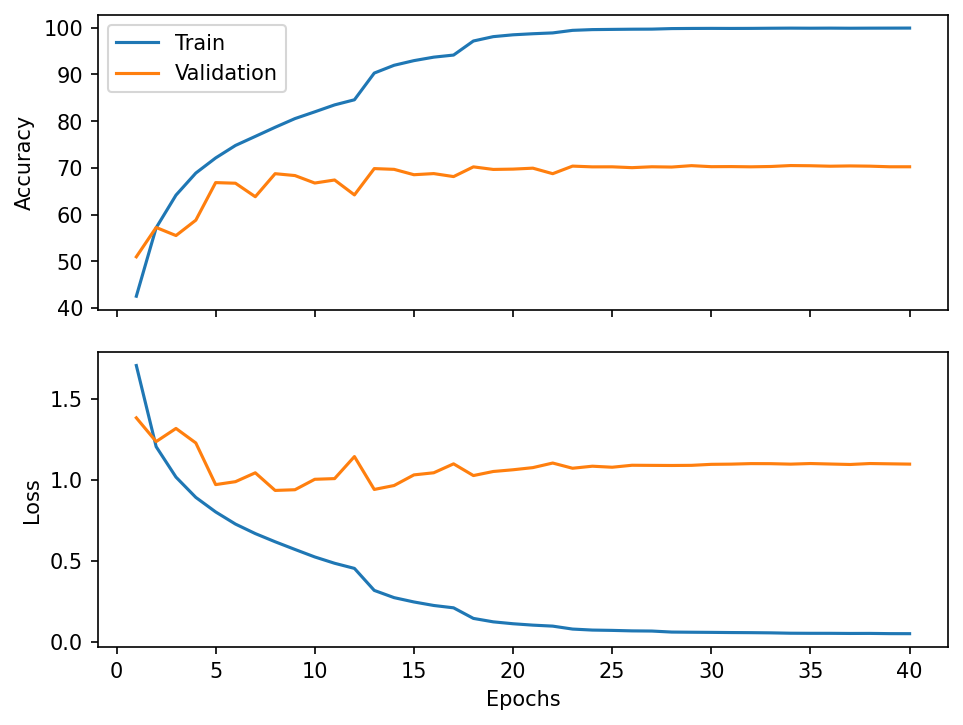

In [16]:
history.display()

#### Question
- En regardant les graphiques ci-dessus, quel est le meilleur moment pour arrêter l'entraînement? 

20-25 epoch

L'algorithme 7.1 du livre (voir http://www.deeplearningbook.org/contents/regularization.html page 244) décrit le paramètre de patience `p` dans le contexte d'un algorithme de *early stopping* (**Attention**: le paramètre de patience `p` du *early stopping* n'a pas de lien avec le paramètre `p` correspondant à l'ordre d'une norme de la section précédente).

#### Exercice
- Analysez l'effet du choix de `p` sur les données de l'entraînement précédent. Regardez pour `p = 1,2,5,10,15`, quelle époque avec quelle précision en validation est choisie. Implémentez un algorithme effectuant du *early stopping* en utilisant l'historique `val_accuracy` de l'entraînement que vous venez d'exécuter pour vos tests (à la place d'entraîner le réseau).

In [20]:
# Historique
val_accuracy_history = history.history['val_acc']

# Patience
for p in [1,2,5,10,15]:
    best_val_accuracy = -np.inf
    best_epoch = -1

    # TODO Implémentez un algorithme de early stopping sur l'historique
    for idx, accuracy in enumerate(val_accuracy_history):
        if idx - best_epoch > p:
            break
        
        if accuracy > best_val_accuracy:
            best_epoch = idx
            best_val_accuracy = accuracy
                
    print("Pour patience p={}, la meilleure époque est {}, avec précision en validation de {:.2f}.".format(p, best_epoch, best_val_accuracy))

Pour patience p=1, la meilleure époque est 1, avec précision en validation de 57.26.
Pour patience p=2, la meilleure époque est 4, avec précision en validation de 66.86.
Pour patience p=5, la meilleure époque est 22, avec précision en validation de 70.39.
Pour patience p=10, la meilleure époque est 33, avec précision en validation de 70.51.
Pour patience p=15, la meilleure époque est 33, avec précision en validation de 70.51.


#### Question

- Identifiez des problèmes pratiques potentiels lors de l'utilisation du *early stopping*. 

p trop faible -> stop trop tôt

p trop élevée -> stop trop tard, burn gpu inutile

### Pour aller plus loin sur le early stopping
Avec Poutyne, on peut effectuer le *early stopping* automatiquement grâce au callback [EarlyStopping](https://poutyne.org/callbacks.html#poutyne.EarlyStopping). Il faut spécifier la métrique à monitorer ainsi que la patience, et on peut également contrôler l'amplitude minimum d'un changement pour que celui-ci soit qualifié comme une amélioration avec le paramètre `min_delta`. L'entraînement va donc s'arrêter automatiquement lorsqu'il n'y a plus d'amélioration pour un nombre consécutif d'époques correspondant à la patience, prévenant possiblement le calcul inutile de plusieurs époques.

In [21]:
# Patience
p = 3

torch.manual_seed(42)
net = CifarNetBatchNorm()

optimizer = optim.SGD(net.parameters(), lr=0.01, weight_decay=1e-3, nesterov=True, momentum=0.9)
scheduler = pt.ReduceLROnPlateau(monitor='val_acc', mode='max', patience=3, factor=0.5, verbose=True)

# Early stopping sous la forme d'un Callback
early_stopping = pt.EarlyStopping(monitor='val_acc', mode='max', min_delta=1e-5, patience=p, verbose=True)

history = train(net, optimizer, cifar_train, n_epoch=40, batch_size=64, callbacks=[scheduler, early_stopping], use_gpu=True)

Epoch:  1/40 Train steps: 625 Val steps: 157 8.13s loss: 1.704021 acc: 42.605000 val_loss: 1.414949 val_acc: 49.760000
Epoch:  2/40 Train steps: 625 Val steps: 157 7.11s loss: 1.207212 acc: 57.165000 val_loss: 1.182339 val_acc: 58.750000
Epoch:  3/40 Train steps: 625 Val steps: 157 7.80s loss: 1.022952 acc: 63.825000 val_loss: 1.112204 val_acc: 61.020000
Epoch:  4/40 Train steps: 625 Val steps: 157 7.74s loss: 0.898383 acc: 68.747500 val_loss: 1.040420 val_acc: 64.750000
Epoch:  5/40 Train steps: 625 Val steps: 157 7.47s loss: 0.808366 acc: 71.920000 val_loss: 0.966349 val_acc: 66.900000
Epoch:  6/40 Train steps: 625 Val steps: 157 7.92s loss: 0.732673 acc: 74.610000 val_loss: 1.060224 val_acc: 65.040000
Epoch:  7/40 Train steps: 625 Val steps: 157 7.03s loss: 0.673500 acc: 76.720000 val_loss: 0.997595 val_acc: 65.930000
Epoch:  8/40 Train steps: 625 Val steps: 157 7.32s loss: 0.625740 acc: 78.395000 val_loss: 0.943768 val_acc: 68.430000
Epoch:  9/40 Train steps: 625 Val steps: 157 7.0

## Partie 3: Dropout
Cette section a pour but d'analyser l'effet du dropout dans un réseau fully connected. Nous ferons cette analyse en reprenant l'exercice du laboratoire 2.

#### Exercice
- Dans le réseau suivant, implémentez la fonction `forward()` formée de couches linéaires suivies d'activation   `Relu` en ajoutant du dropout ([Indice](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.dropout)) après l'activation si `self.use_dropout == True` . Utilisez une probabilité de dropout de `0.3` indiqué par `self.dropout_p` et ne faites pas de dropout sur la couche de sortie. N'ajoutez **pas de softmax** car la fonction `deeplib.training.train()` utilise par défaut `CrossEntropyLoss`, ce qui le fait pour vous. 

> **ATTENTION!** Vous devez bien fixer l'argument `training` de dropout. Vous pouvez savoir si modèle est en entraînement ou en évaluation avec `self.training`.

In [22]:
class MnistModel(torch.nn.Module):
    
    def __init__(self, n_layers, hidden_size=100, use_dropout=True, dropout_p=0.3):
        super().__init__()
        torch.manual_seed(42)
        self.use_dropout = use_dropout
        self.hidden_size = hidden_size
        self.dropout_p = dropout_p
        
        # Initialisation des couches
        layer_sizes = [28*28] + [self.hidden_size]*n_layers
        self.layers = nn.ModuleList()
        for input_size, output_size in zip(layer_sizes[:-1], layer_sizes[1:]):
            layer = nn.Linear(input_size, output_size)
            layer.weight.data.normal_(0.0, math.sqrt(2 / input_size))
            layer.bias.data.fill_(0)
            self.layers.append(layer)
            
        
        # Couche de sortie avec une neurone par classe
        self.output_layer = nn.Linear(hidden_size,10)
        self.output_layer.weight.data.normal_(0.0, math.sqrt(2 / hidden_size))
        self.output_layer.bias.data.fill_(0)              

    def forward(self, x):
        out = x.view(-1, 28*28)
        for layer in self.layers:
            out = layer(out)
            torch.relu_(out)
            if self.use_dropout:
                out = torch.nn.functional.dropout(out, p=self.dropout_p, training=self.training)
            
        return self.output_layer(out)

#### Question
- Quelle est l'importance de l'argument `training` de la fonction de dropout? 

On ne veut pas modifier les poids lors de l'inférence

Entraînez un réseau avec dropout et un réseau sans dropout.

In [23]:
# Paramètres
lr = 0.01
batch_size = 64
n_epoch = 20

Réseau sans dropout:

Epoch:  1/20 Train steps: 750 Val steps: 188 6.72s loss: 0.372107 acc: 89.187500 val_loss: 0.208891 val_acc: 93.941667
Epoch:  2/20 Train steps: 750 Val steps: 188 5.85s loss: 0.169816 acc: 95.037500 val_loss: 0.157313 val_acc: 95.158333
Epoch:  3/20 Train steps: 750 Val steps: 188 5.61s loss: 0.123281 acc: 96.341667 val_loss: 0.126774 val_acc: 96.241667
Epoch:  4/20 Train steps: 750 Val steps: 188 5.69s loss: 0.096359 acc: 97.131250 val_loss: 0.111554 val_acc: 96.625000
Epoch:  5/20 Train steps: 750 Val steps: 188 5.79s loss: 0.079951 acc: 97.625000 val_loss: 0.103745 val_acc: 96.800000
Epoch:  6/20 Train steps: 750 Val steps: 188 5.58s loss: 0.064616 acc: 98.120833 val_loss: 0.107728 val_acc: 96.891667
Epoch:  7/20 Train steps: 750 Val steps: 188 5.97s loss: 0.057393 acc: 98.337500 val_loss: 0.097787 val_acc: 96.966667
Epoch:  8/20 Train steps: 750 Val steps: 188 6.40s loss: 0.049091 acc: 98.554167 val_loss: 0.095555 val_acc: 97.175000
Epoch:  9/20 Train steps: 750 Val steps: 188 5.6

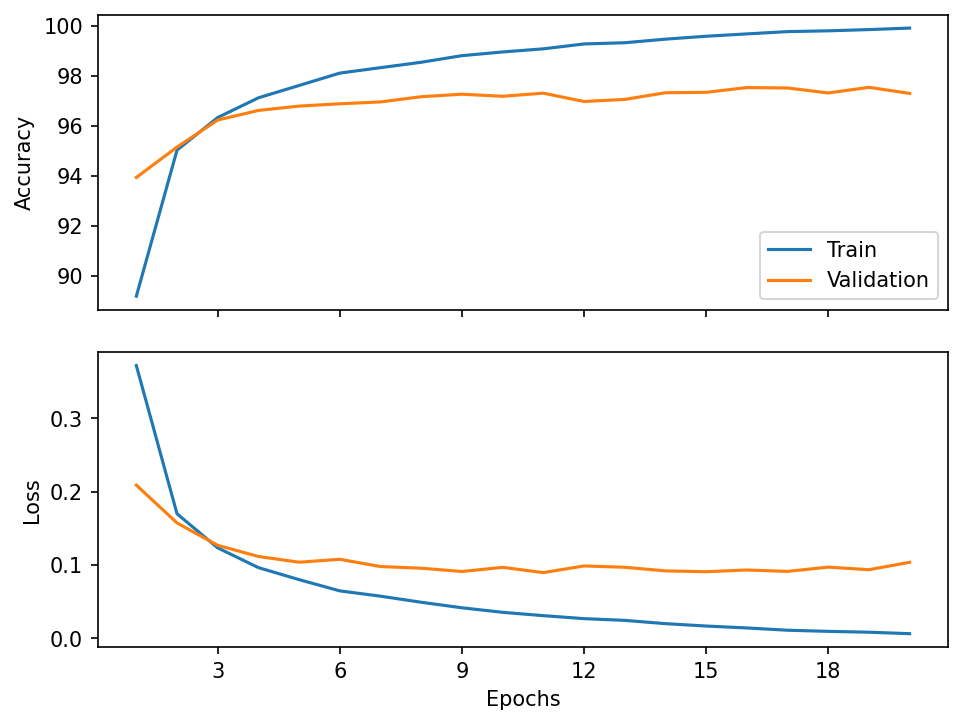

Test steps: 157 0.75s test_loss: 0.087189 test_acc: 97.720000                                 
Précision en test: 97.72


In [24]:
net_without_dropout = MnistModel(2, use_dropout=False)
optimizer_without_dropout = optim.SGD(net_without_dropout.parameters(), lr, nesterov=True, momentum=0.9)

history_without_dropout = train(net_without_dropout, optimizer_without_dropout, mnist_train, n_epoch, batch_size, use_gpu=True)
history_without_dropout.display()
print('Précision en test: {:.2f}'.format(test(net_without_dropout, mnist_test, batch_size)))

Réseau avec dropout:

Epoch:  1/20 Train steps: 750 Val steps: 188 6.94s loss: 0.582715 acc: 81.887500 val_loss: 0.230156 val_acc: 93.341667
Epoch:  2/20 Train steps: 750 Val steps: 188 5.86s loss: 0.303017 acc: 90.910417 val_loss: 0.172379 val_acc: 94.791667
Epoch:  3/20 Train steps: 750 Val steps: 188 5.77s loss: 0.245986 acc: 92.697917 val_loss: 0.147211 val_acc: 95.625000
Epoch:  4/20 Train steps: 750 Val steps: 188 5.99s loss: 0.214050 acc: 93.612500 val_loss: 0.131714 val_acc: 96.233333
Epoch:  5/20 Train steps: 750 Val steps: 188 5.94s loss: 0.189757 acc: 94.277083 val_loss: 0.124397 val_acc: 96.325000
Epoch:  6/20 Train steps: 750 Val steps: 188 6.14s loss: 0.176506 acc: 94.641667 val_loss: 0.119040 val_acc: 96.450000
Epoch:  7/20 Train steps: 750 Val steps: 188 6.43s loss: 0.162175 acc: 95.200000 val_loss: 0.113025 val_acc: 96.475000
Epoch:  8/20 Train steps: 750 Val steps: 188 5.78s loss: 0.150737 acc: 95.527083 val_loss: 0.113203 val_acc: 96.575000
Epoch:  9/20 Train steps: 750 Val steps: 188 5.8

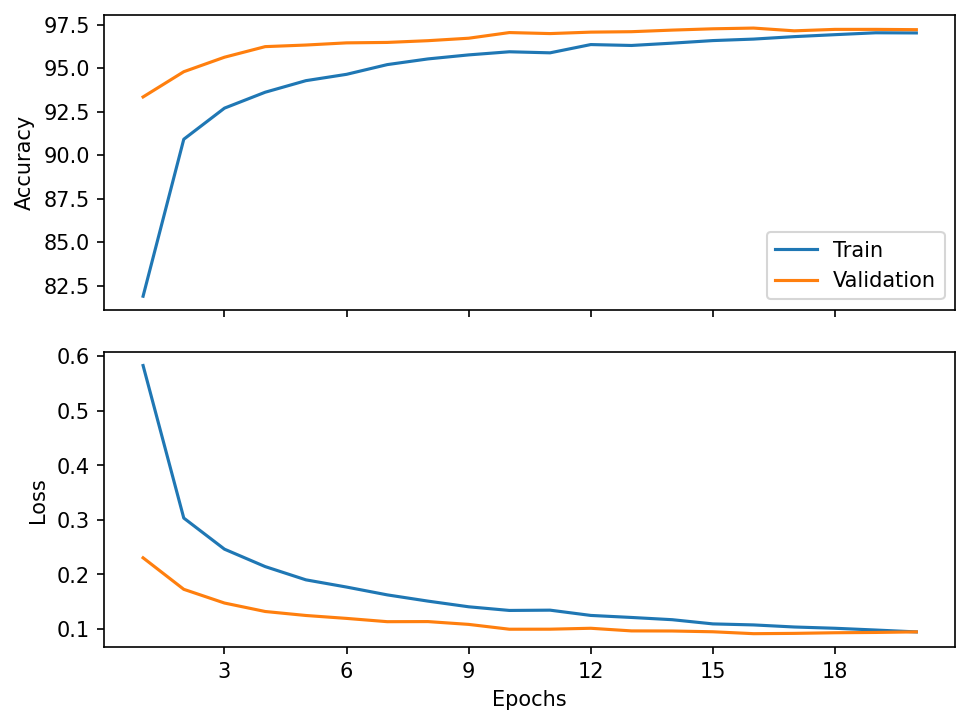

Test steps: 157 0.77s test_loss: 0.083814 test_acc: 97.410000                                  
Précision en test: 97.41


In [25]:
net_with_dropout = MnistModel(2, use_dropout=True, dropout_p=0.3)
optimizer_with_dropout = optim.SGD(net_with_dropout.parameters(), lr, nesterov=True, momentum=0.9)

history_with_dropout = train(net_with_dropout, optimizer_with_dropout, mnist_train, n_epoch, batch_size, use_gpu=True)
history_with_dropout.display()
print('Précision en test: {:.2f}'.format(test(net_with_dropout, mnist_test, batch_size)))

#### Questions
- Quel est l'effet du dropout sur l'entraînement du réseau? 

Entrainement plus lent, mais aucun surapprentissage, les accuracy des train et de validation de rapproche au lieu de s'éliogner dans les méthodes standard
    
- Essayez plusieurs valeurs de dropout et observez les effets.

trop faible -> aucun effet

trop élévé -> difficulté à apprendre